This is a demo adapted for our own dataset, provided from the OS2D library (https://github.com/aosokin/os2d), so special thanks to Anton Osokin, Denis Sumin, and Vasily Lomakin. This notebook is here to illustrate an application of the OS2D method on one image.
Demo assumes the OS2D code is [installed](./INSTALL.md).

To install the OS2D library, use the following command:
git clone https://github.com/aosokin/os2d

Then, either create a virtual environment and set the Python version to 3.7. Check to make sure you have the right version by using:
python --version

Also ensure that you have the right ipython and pip versions and cuda=10.0.

In [ ]:
!pip install pytorch=1.4 torchvision=0.5 cudatoolkit=10.0 -c pytorch

# more dependencies
!pip install tqdm=4.42.1 pandas=1.0.1 matplotlib=3.1.3 pyyaml=5.3 scipy=1.4.1
!pip install -c conda-forge yacs=0.1.6

# to monitor GPU usage on a cluster
!pip install gpustat==0.6.0

# to view train logs in visdom
!pip install visdom==0.1.8.9

The following instructions are specifically for those using Google Colaboratory in order to access files and install missing dependencies.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/os2d

/content/drive/MyDrive/os2d


In [ ]:
!pip install yacs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The code demo begins here:

In [ ]:
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio

logger = setup_logger("OS2D")

In [ ]:
# use GPU if have available
cfg.is_cuda = torch.cuda.is_available()

Download the trained model (is the script does not work download from [Google Drive](https://drive.google.com/open?id=1l_aanrxHj14d_QkCpein8wFmainNAzo8) and put to models/os2d_v2-train.pth). See [README](./README.md) to get links for other released models.

In [ ]:
!./os2d/utils/wget_gdrive.sh models/os2d_v2-train.pth 1l_aanrxHj14d_QkCpein8wFmainNAzo8

/bin/bash: ./os2d/utils/wget_gdrive.sh: Permission denied


In [ ]:
cfg.init.model = "models/os2d_v2-train.pth"
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)

2022-08-15 07:55:49,983 OS2D INFO: Building the OS2D model


INFO:OS2D:Building the OS2D model


2022-08-15 07:55:50,517 OS2D INFO: Creating model on CPU


INFO:OS2D:Creating model on CPU


2022-08-15 07:55:50,523 OS2D INFO: Reading model file models/os2d_v2-train.pth


INFO:OS2D:Reading model file models/os2d_v2-train.pth


2022-08-15 07:55:52,617 OS2D INFO: Loaded complete model from checkpoint


INFO:OS2D:Loaded complete model from checkpoint


2022-08-15 07:55:52,625 OS2D INFO: Cannot find 'optimizer' in the checkpoint file. Initializing optimizer from scratch.


INFO:OS2D:Cannot find 'optimizer' in the checkpoint file. Initializing optimizer from scratch.


2022-08-15 07:55:52,633 OS2D INFO: OS2D has 139 blocks of 10169478 parameters (before freezing)


INFO:OS2D:OS2D has 139 blocks of 10169478 parameters (before freezing)


2022-08-15 07:55:52,644 OS2D INFO: OS2D has 139 blocks of 10169478 trainable parameters


INFO:OS2D:OS2D has 139 blocks of 10169478 trainable parameters


Get the image where to detect and two class images.

In [ ]:
input_image = read_image('data/demo/boat312.png')
class_images = [read_image("data/demo/boat397_class_image.png"), read_image("data/demo/boat12_class_image.png")]
class_ids = [1, 1]

Use torchvision to convert images to torch.Tensor and to apply normalization.

In [ ]:
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

Prepare the input image

In [ ]:
h, w = get_image_size_after_resize_preserving_aspect_ratio(h=input_image.size[1],
                                                               w=input_image.size[0],
                                                               target_size=1500)
input_image = input_image.resize((w, h))

input_image_th = transform_image(input_image)
input_image_th = input_image_th.unsqueeze(0)
if cfg.is_cuda:
    input_image_th = input_image_th.cuda()


Prepare the class images

In [ ]:
class_images_th = []
for class_image in class_images:
    h, w = get_image_size_after_resize_preserving_aspect_ratio(h=class_image.size[1],
                                                               w=class_image.size[0],
                                                               target_size=cfg.model.class_image_size)
    class_image = class_image.resize((w, h))

    class_image_th = transform_image(class_image)
    if cfg.is_cuda:
        class_image_th = class_image_th.cuda()

    class_images_th.append(class_image_th)

Run the network with one command

In [ ]:
with torch.no_grad():
     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(images=input_image_th, class_images=class_images_th)

Alternatively one can run the stages of the model separatly, which is convenient, e.g., for sharing class feature extraction between many input images.

In [ ]:
# with torch.no_grad():
#     feature_map = net.net_feature_maps(input_image_th)

#     class_feature_maps = net.net_label_features(class_images_th)
#     class_head = net.os2d_head_creator.create_os2d_head(class_feature_maps)

#     loc_prediction_batch, class_prediction_batch, _, fm_size, transform_corners_batch = net(class_head=class_head,
#                                                                                             feature_maps=feature_map)


Convert image organized in batches into images organized in pyramid levels. Not needed in the demo, but essential for multiple images in a batch and multiple pyramid levels.

In [ ]:

image_loc_scores_pyramid = [loc_prediction_batch[0]]
image_class_scores_pyramid = [class_prediction_batch[0]]
img_size_pyramid = [FeatureMapSize(img=input_image_th)]
transform_corners_pyramid = [transform_corners_batch[0]]


Decode network outputs into detection boxes

In [ ]:
boxes = box_coder.decode_pyramid(image_loc_scores_pyramid, image_class_scores_pyramid,
                                           img_size_pyramid, class_ids,
                                           nms_iou_threshold=cfg.eval.nms_iou_threshold,
                                           nms_score_threshold=cfg.eval.nms_score_threshold,
                                           transform_corners_pyramid=transform_corners_pyramid)

# remove some fields to lighten visualization                                       
boxes.remove_field("default_boxes")


In [ ]:
# Note that the system outputs the correaltions that lie in the [-1, 1] segment as the detection scores (the higher the better the detection).
scores = boxes.get_field("scores")

Show class images

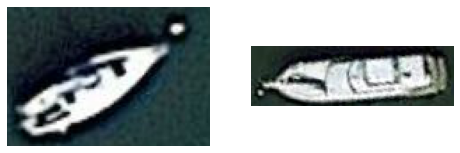

In [ ]:
figsize = (8, 8)
fig=plt.figure(figsize=figsize)
columns = len(class_images)
for i, class_image in enumerate(class_images):
    fig.add_subplot(1, columns, i + 1)
    plt.imshow(class_image)
    plt.axis('off')


Show fixed number of detections that are above a certain threshold. Yellow rectangles show detection boxes. Each box has a class label and the detection scores (the higher the better the detection). Red parallelograms illustrate the affine transformations that align class images to the input image at the location of detection.

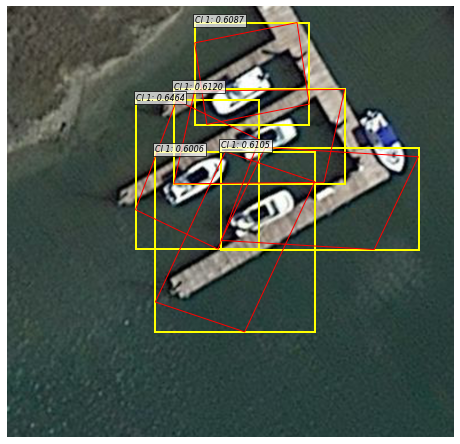

In [ ]:
plt.rcParams["figure.figsize"] = figsize

cfg.visualization.eval.max_detections = 5
cfg.visualization.eval.score_threshold = float("-inf")
visualizer.show_detections(boxes, input_image,
                           cfg.visualization.eval)